<a href="https://colab.research.google.com/github/Kozhedu/recommender_systems/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv', parse_dates=['Date'], index_col=['Date'])

In [3]:
data.head()

,spx
Date,
1994-01-06,467.119995
1994-01-07,469.899994
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013


In [4]:
%matplotlib inline

<AxesSubplot:xlabel='Date'>

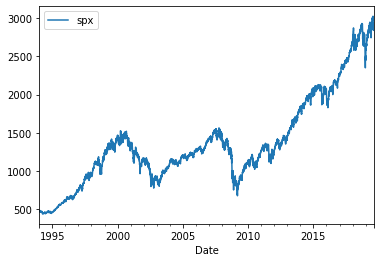

In [5]:
data.plot()

In [6]:
train_df = data.loc[:'2018-12-31']
test_df = data.loc['2019-01-01':]
train_df.shape, test_df.shape

((6518, 1), (174, 1))

In [7]:
from matplotlib import pyplot as plt

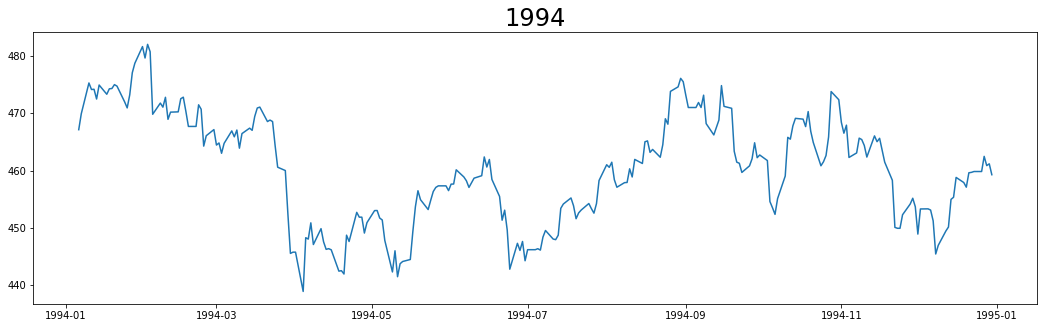

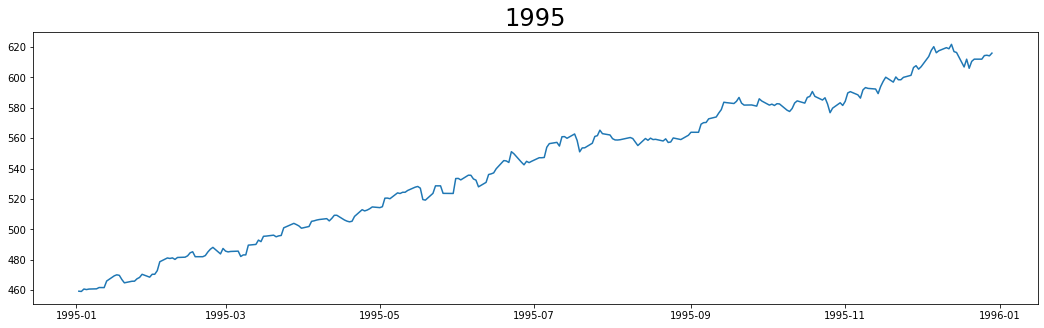

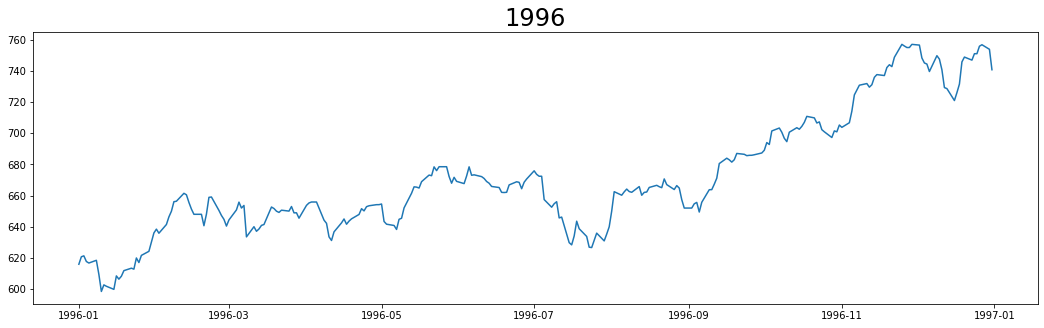

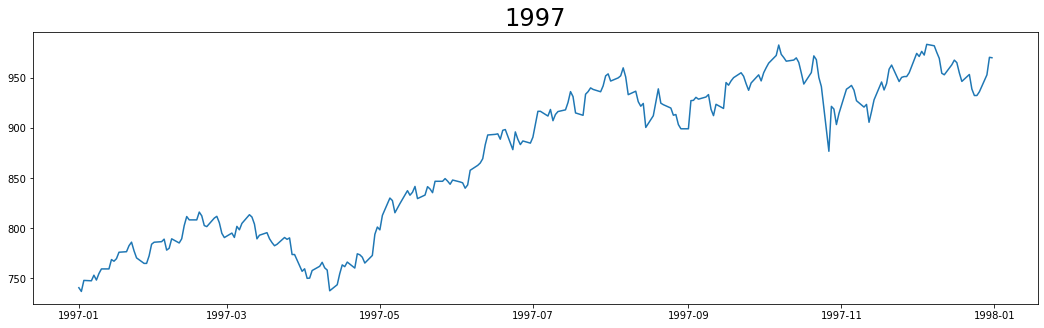

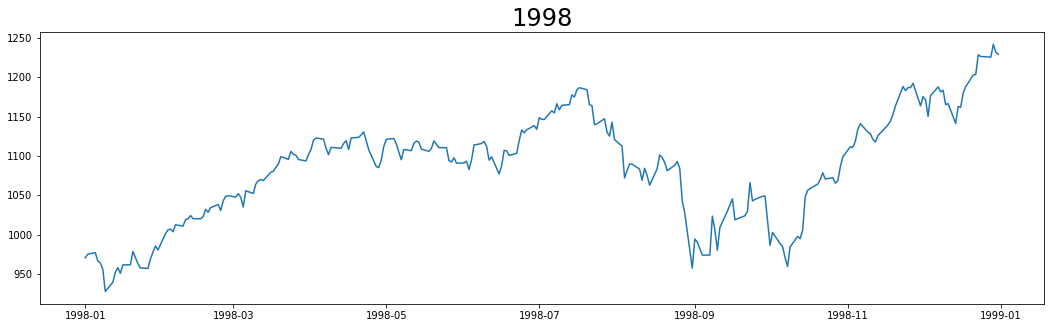

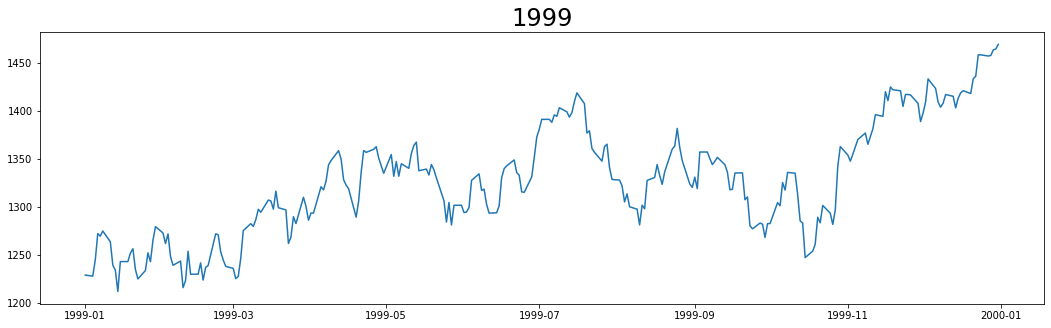

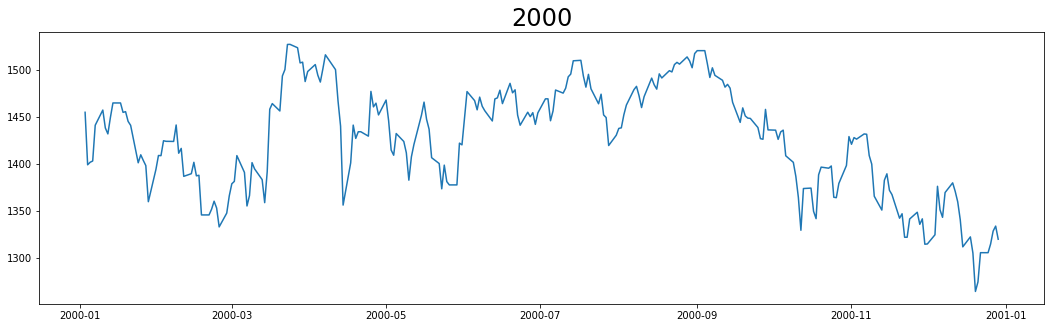

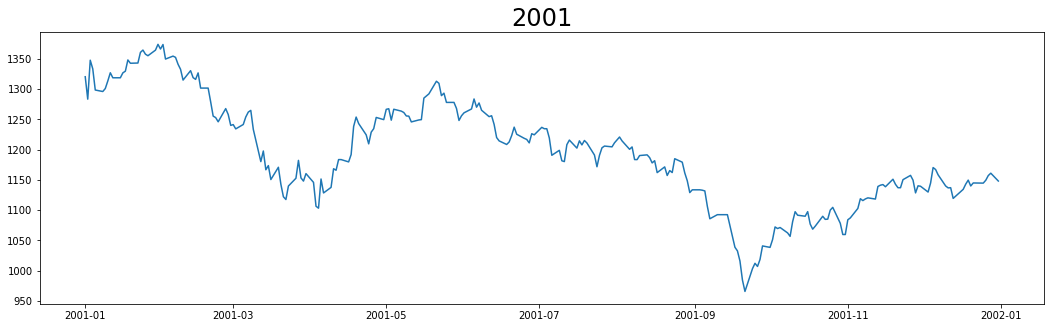

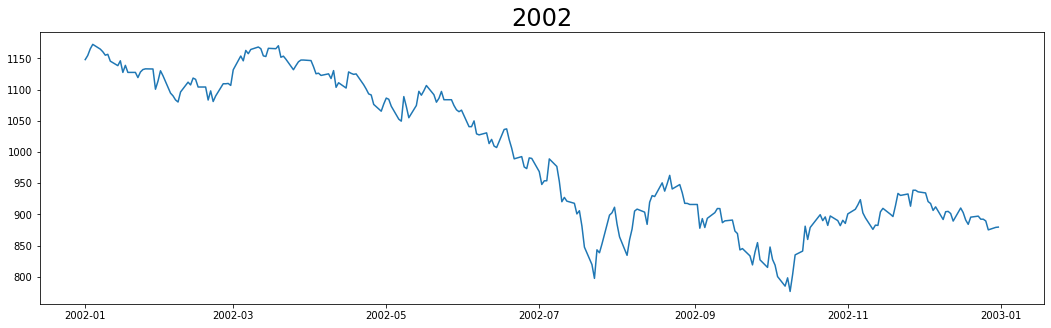

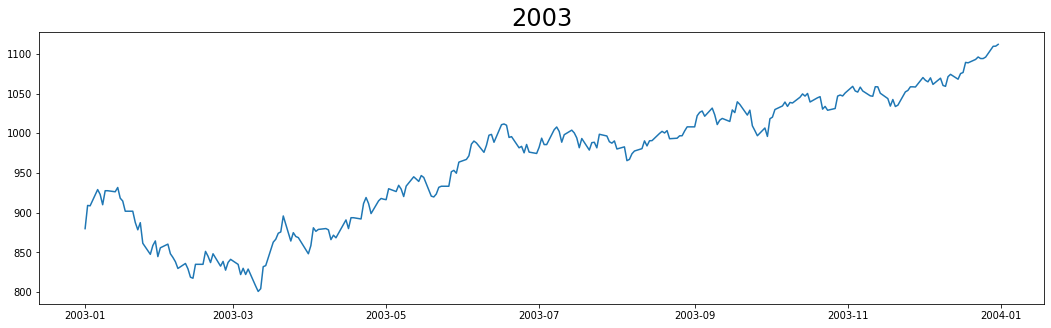

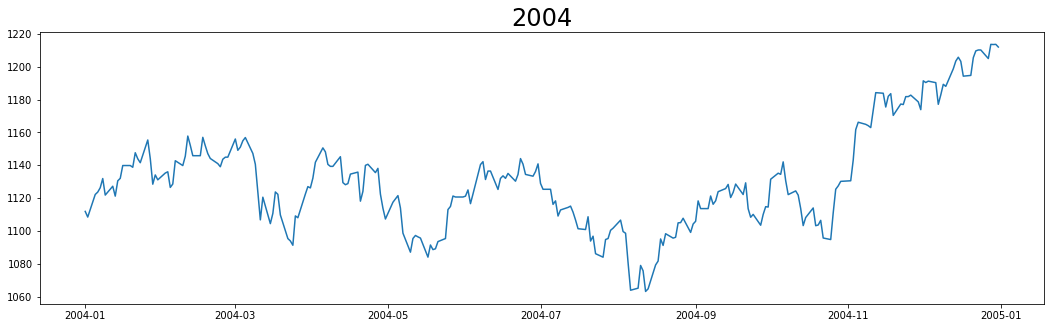

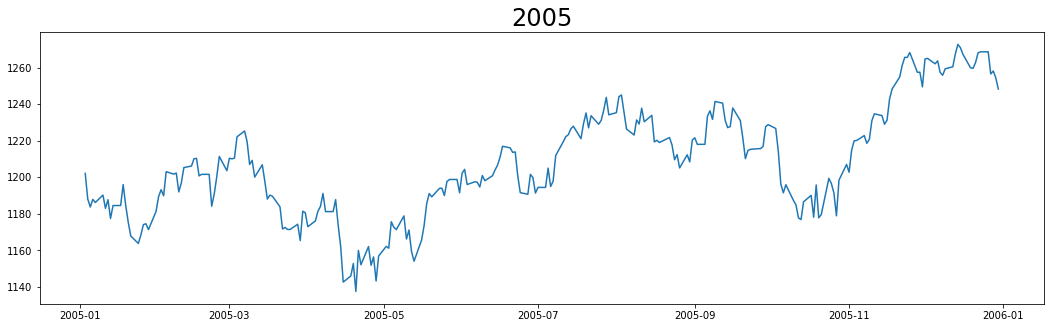

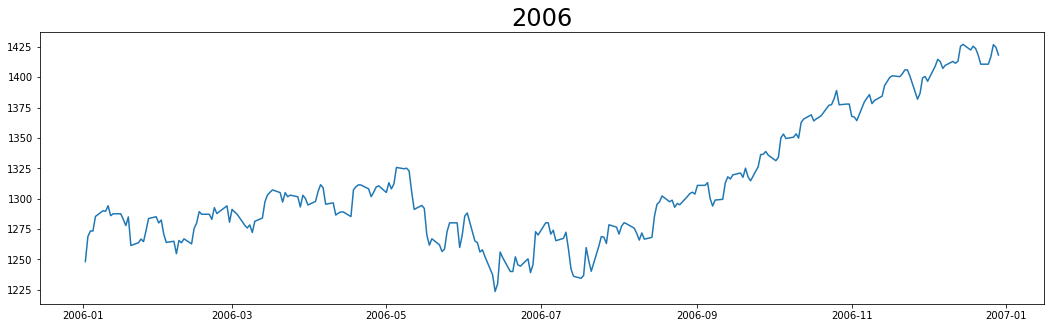

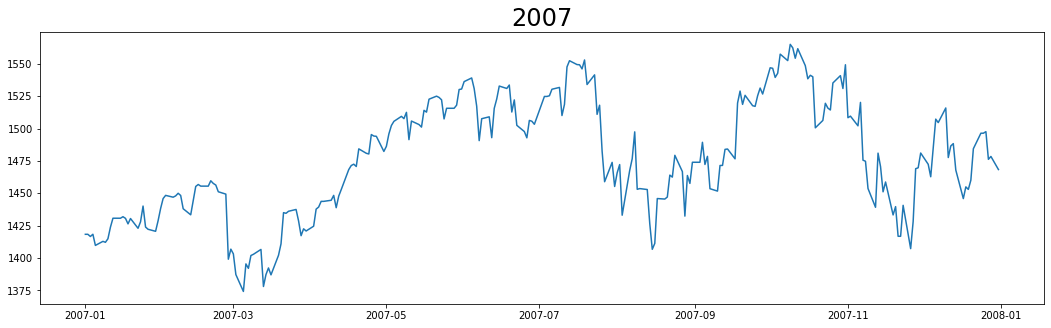

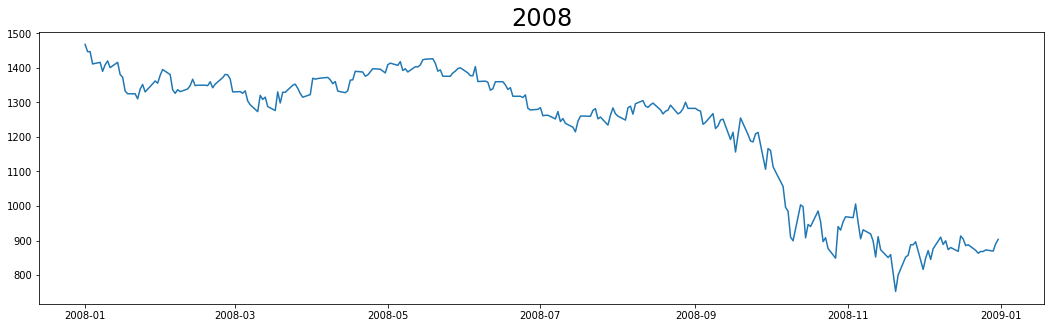

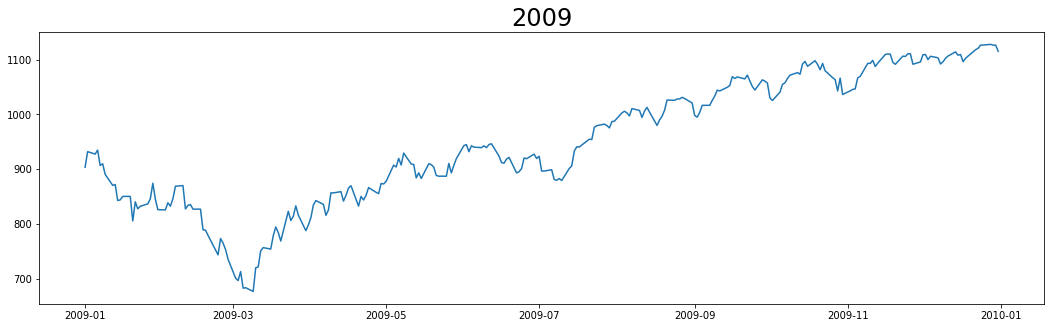

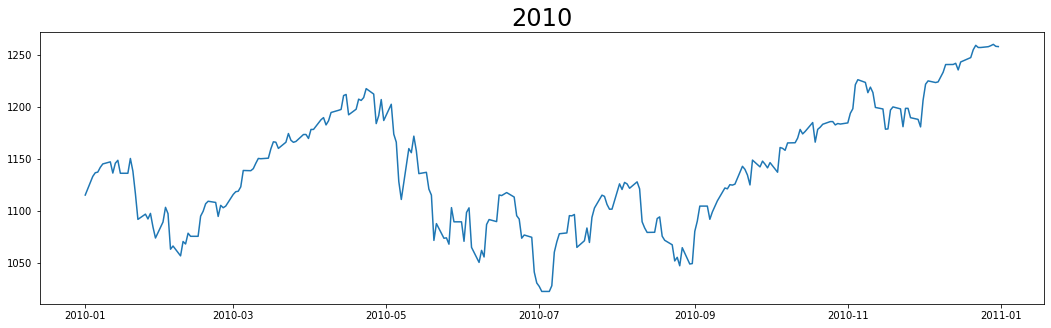

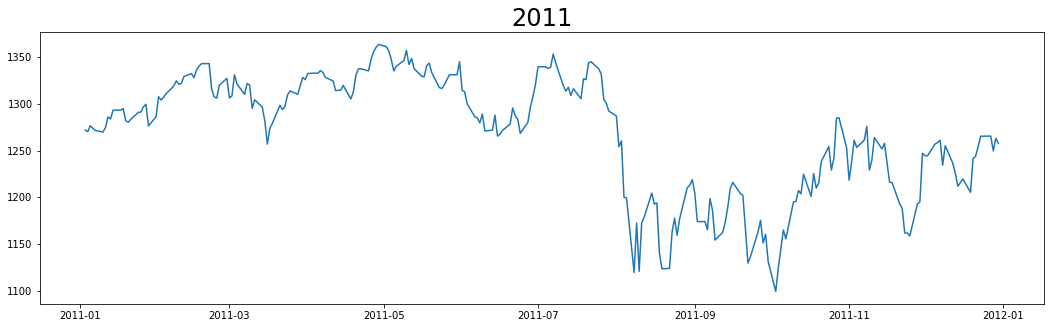

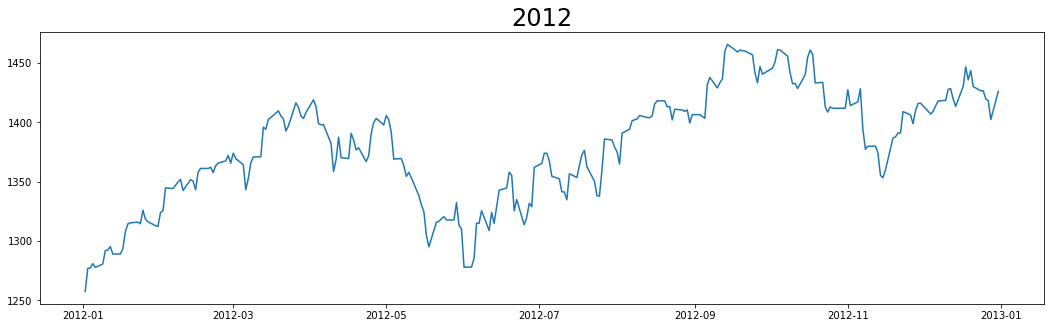

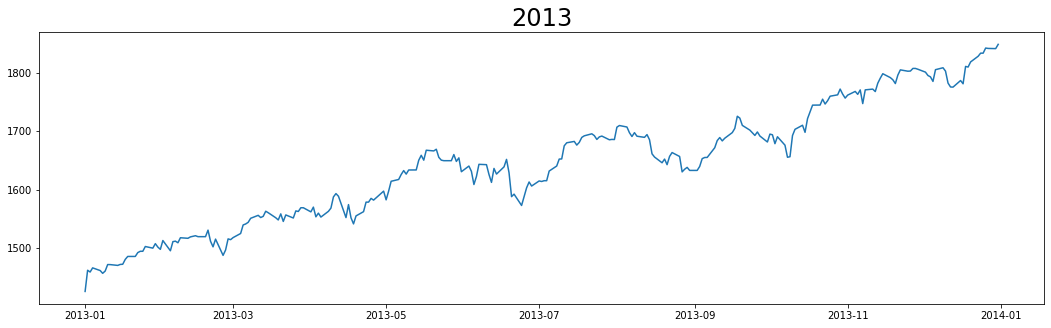

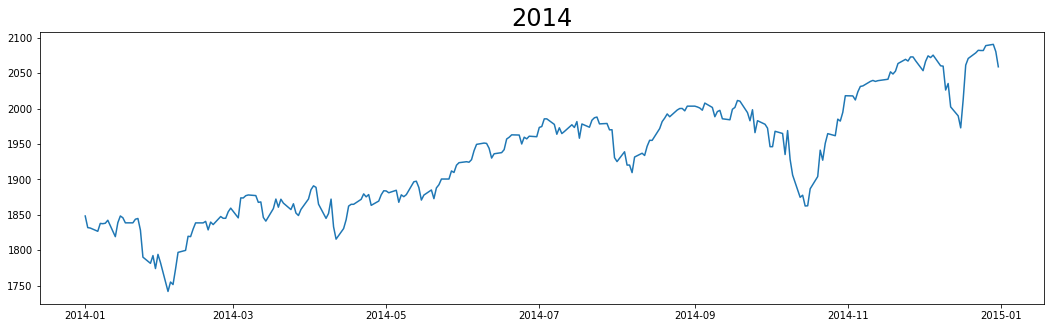

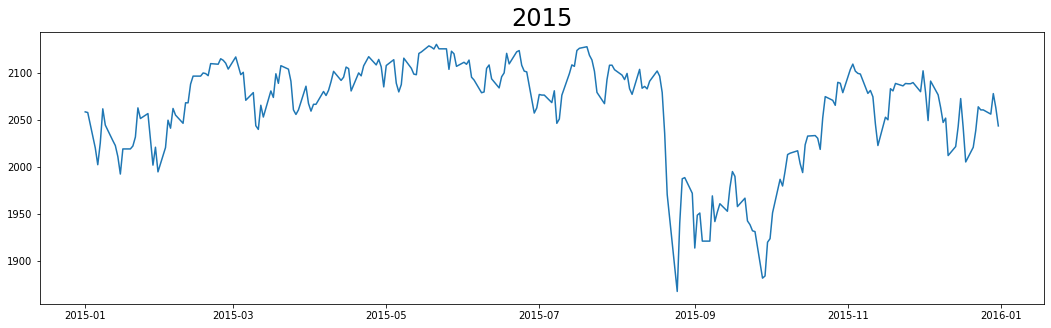

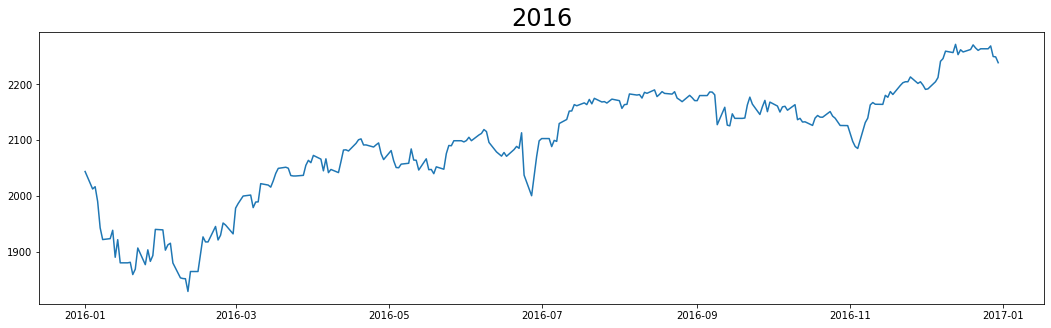

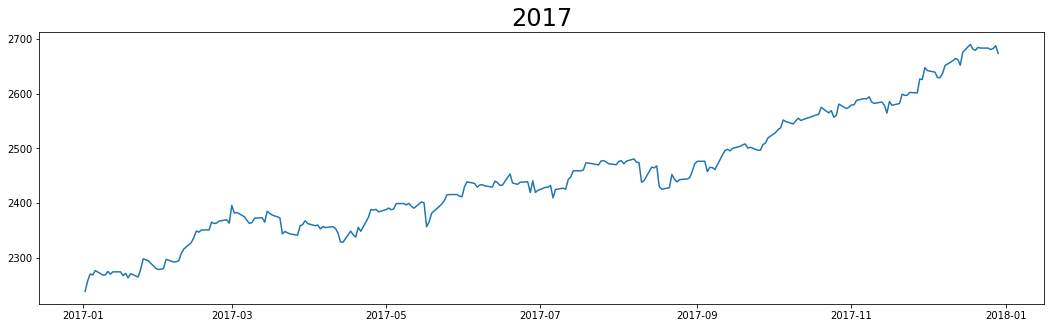

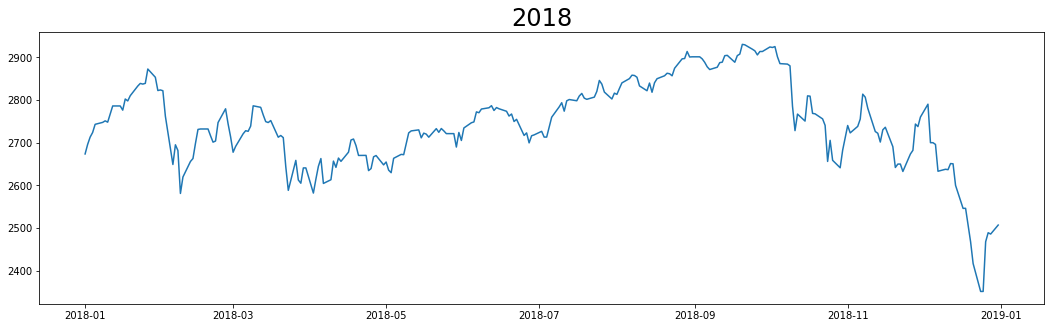

In [8]:
plt.rcParams['figure.figsize'] = 18,5

for year in set(train_df.index.year):
  plt.plot(train_df[['spx']].loc[train_df.index.year==year])
  plt.title(str(year),size=24)
  plt.show()

Сезонная декомпозиция

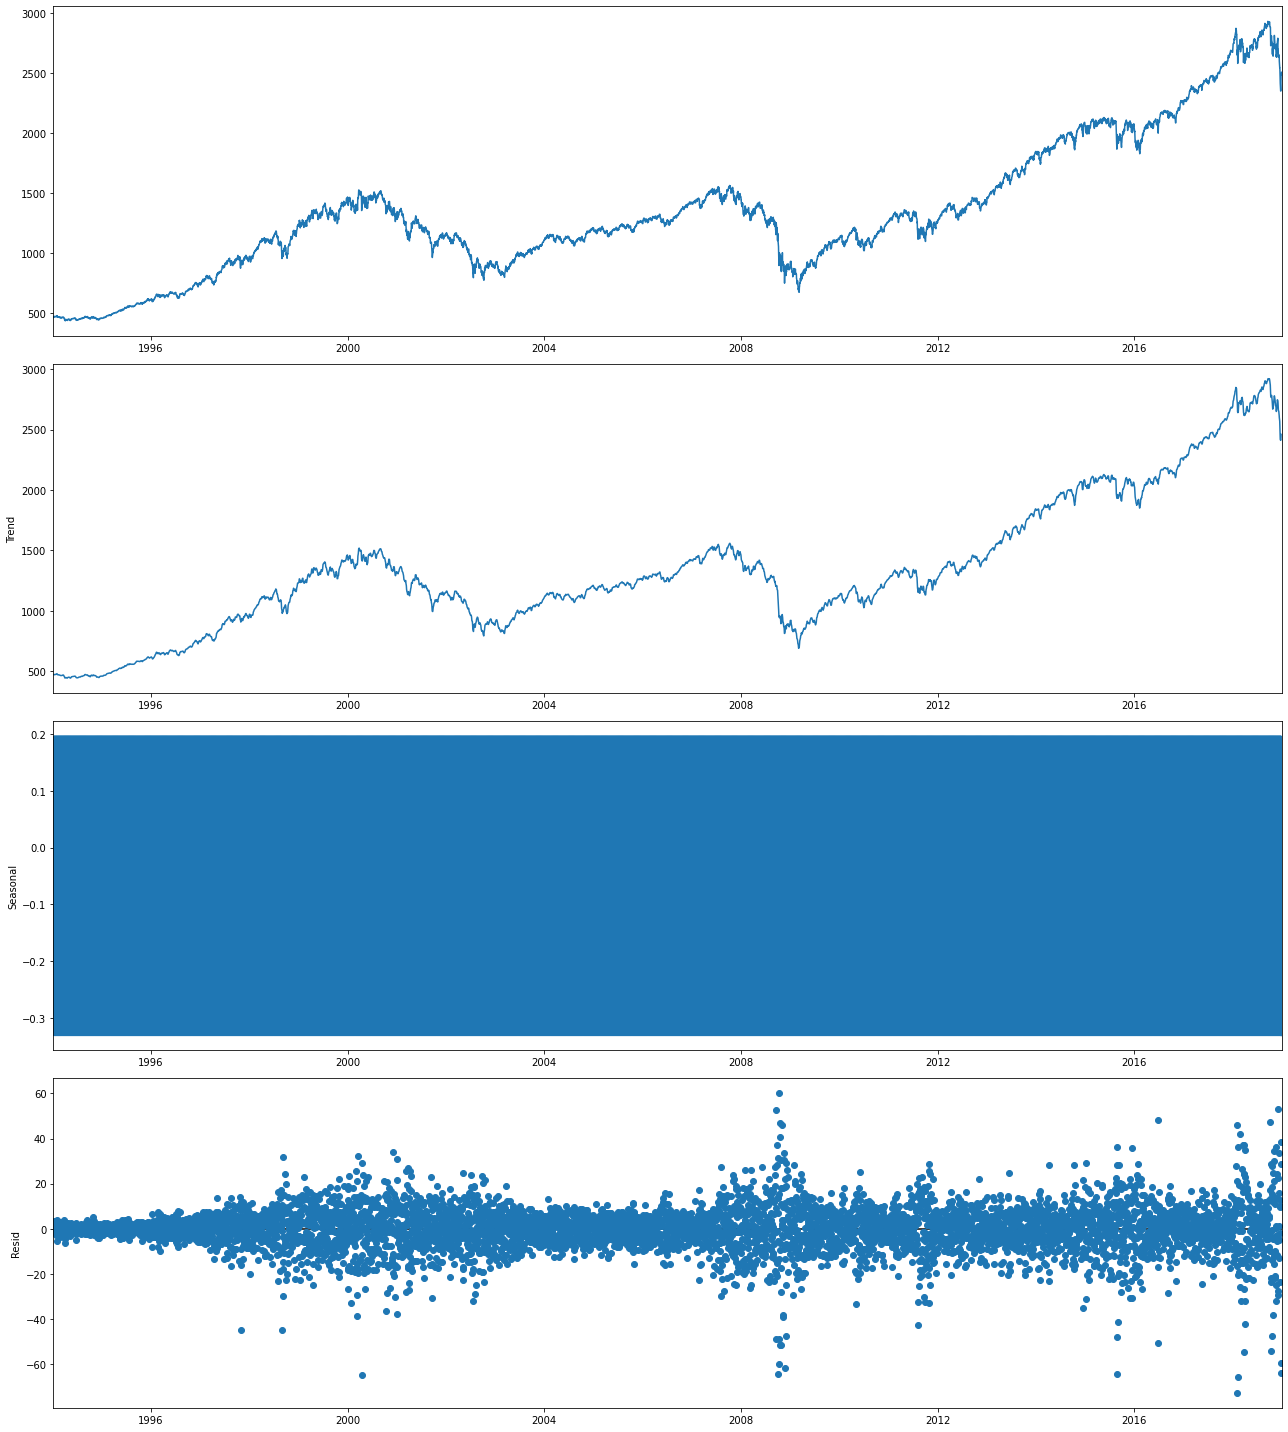

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = 18, 20
result = seasonal_decompose(train_df)
result.plot()
plt.show()

Первые 20 значений

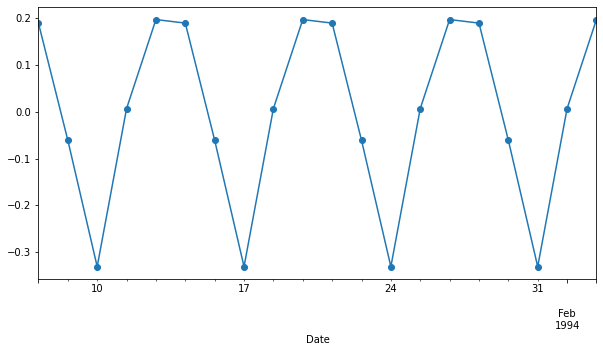

In [10]:
plt.rcParams['figure.figsize'] = 10,5
result.seasonal[:20].plot(marker = 'o')
plt.show()

Построение скользящих средних

Простое скользящее среднее (Simple Moving Average, SMA):

SMAt = (Xt-q+1+...Xt)/q

Количество точек для суммирования определяется размером окна (q). Чем больше размер, тем больше данные сглаживаются.

Таким образом, в скользящем среднем мы суммируем несколько последовательных точек временного ряда и делим эту сумму на количество самих точек, то есть считаем математическое усреднение за определённый период.

Для сглаживания мы будем использовать встроенный метод pandas.Series.rolling() — он принимает на вход параметр window и ожидает после себя агрегирующую функцию для сглаживания (обычно используется среднее).




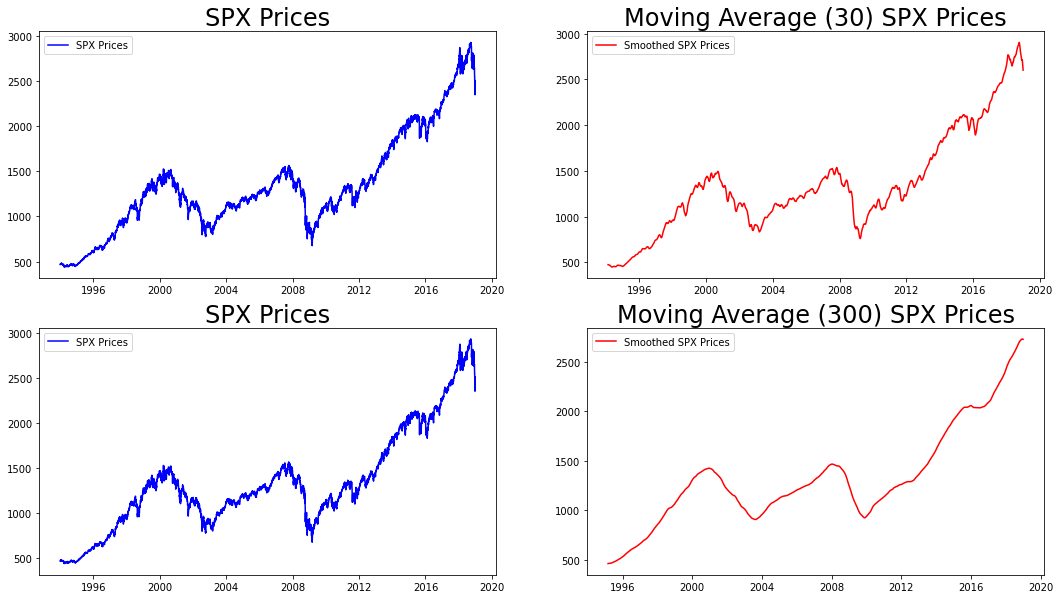

In [11]:
plt.rcParams['figure.figsize'] = 18,10

fig, ax = plt.subplots(2,2)

#Окно в месяц (Window = 30)
ax[0,0].plot(train_df.spx, color = 'blue', label = 'SPX Prices')
ax[0,0].set_title('SPX Prices', size = 24)
ax[0,0].legend()

ax[0,1].plot(train_df.spx.rolling(window=30).mean(), color = 'red', label = 'Smoothed SPX Prices')
ax[0,1].set_title('Moving Average (30) SPX Prices', size = 24)
ax[0,1].legend()

#Окно в год (Window = 300)
ax[1,0].plot(train_df.spx, color = 'blue', label = 'SPX Prices')
ax[1,0].set_title('SPX Prices', size = 24)
ax[1,0].legend()

ax[1,1].plot(train_df.spx.rolling(window=300).mean(), color = 'red', label = 'Smoothed SPX Prices')
ax[1,1].set_title('Moving Average (300) SPX Prices', size = 24)
ax[1,1].legend()

График автокорреляций разного порядка называется коррелограмма. Его довольно просто построить с помощью метода plot_acf из пакета statsmodels.graphics.tsaplots. Методу необходимо передать всё тот же временной ряд с индексом-датой.

rk=∑N−ki=1(Yi−Y¯)(Yi+k−Y¯)∑Ni=1(Yi−Y¯)2

НЕ ПОНЯЛА  - НУЖНО ЧИТАТЬ

In [12]:
import statsmodels.graphics.tsaplots as sgt

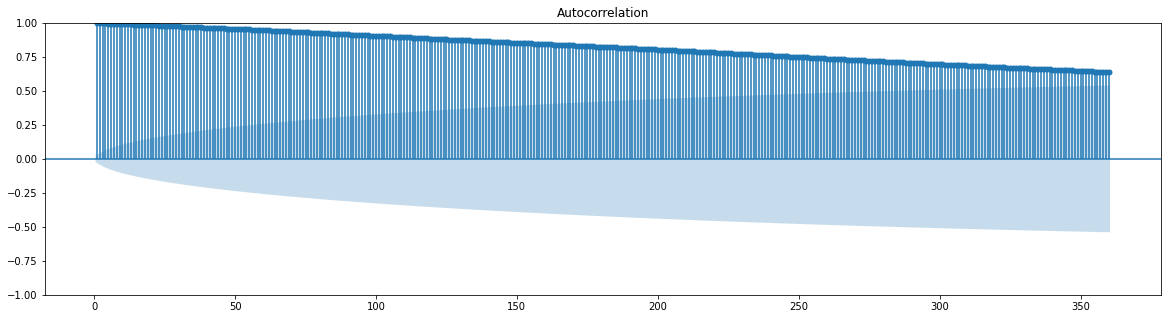

In [13]:
plt.rcParams['figure.figsize'] = 20, 5
sgt.plot_acf(train_df, zero = False, lags = 360)
plt.show()

График частичной автокорреляции

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


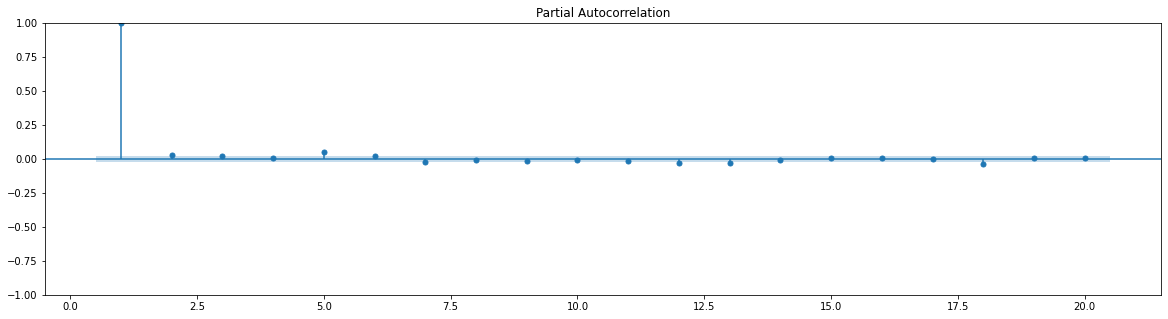

In [14]:
plt.rcParams['figure.figsize'] = 20, 5
sgt.plot_pacf(train_df, zero = False, lags = 20)
plt.show()

Если будет такой график , то параметр p надо ставить = 1

Тест Дики-Фуллера на стационарность ряда

В тесте формулируется две гипотезы:

нулевая гипотеза (H0): временной ряд нестационарный, то есть имеет некоторый тренд и сезонную компоненту;

альтернативная гипотеза (H1): временной ряд стационарный, то есть не имеет тренда и сезонной компоненты, и данные скорее случайны.

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
adfuller(train_df['spx'])

(-0.3312809396965244,
 0.9209556878912157,
 10,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 53000.32567590042)

In [17]:
result = adfuller(train_df['spx'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: -0.3312809396965244
p-value: 0.9209556878912157
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Статистика больше всех критических значений 1%, 5%, 10%, поэтому нулевую гипотезу H0 нельзя отвергнуть  - цены SPX не являются стационарными

Построение карролерограмм в отдельной функции

In [18]:
def plot_acf_pacf(series):
  plt.rcParams['figure.figsize'] = 18, 5

  fig, axes = plt.subplots(1,2)

  sgt.plot_acf(series, lags = 40, ax = axes[0])
  sgt.plot_pacf(series, lags = 40, ax = axes[1])
  plt.show()

Приводим ряд к стационарности

Дифференцирование ряда:

y_newt = yt-yt-1
где
y_newt - Дифференцирование значение ряда t
yt - фактическое значение ряда t
y t-1 - фактическое значение ряда t-1

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


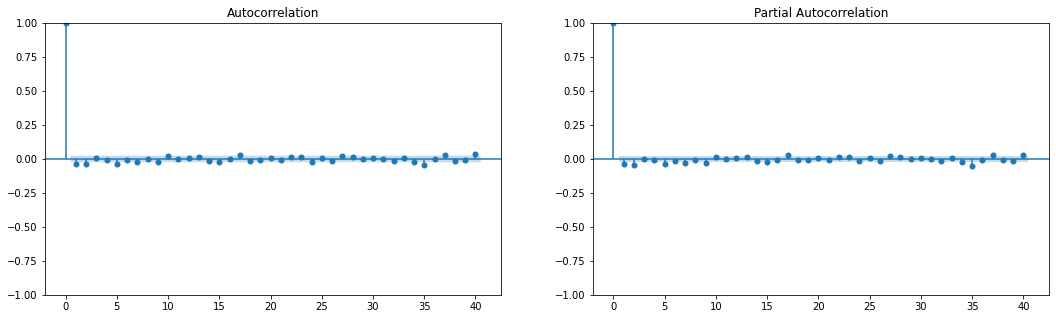

adf:  -27.326250201731145
p-value:  0.0
	1%: -3.431
	5%: -2.862
	10%: -2.567
ряд стационарен


In [19]:
train_df_1 = train_df['spx'].diff(1).dropna()

plot_acf_pacf(train_df_1)

test1 = adfuller(train_df_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
for key, value in test1[4].items():
	print(f"\t{key}: {value:.3f}")
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

ARIMA, SARIMA

 ARMA — это авторегрессионное скользящее среднее, или модель авторегрессии-скользящего среднего. В ней p авторегрессионных слагаемых и q слагаемых скользящего среднего шумовой компоненты:

p — параметр авторегрессионной модели (AR(p));
q — параметр скользящего среднего (MA(q))

ARMA p,d,q = 1 (d - сколько ряд дефференцировали?)
Сезонная модель - SARIMA
m=5 p,d,q = 1

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [21]:
train_df['spx'].diff(1).dropna()

Date
1994-01-07      2.779999
1994-01-10      5.369995
1994-01-11     -1.139984
1994-01-12      0.040009
1994-01-13     -1.700012
                 ...    
2018-12-25      0.000000
2018-12-26    116.599854
2018-12-27     21.130127
2018-12-28     -3.090088
2018-12-31     21.110107
Name: spx, Length: 6517, dtype: float64

In [22]:
arima_model = ARIMA(train_df['spx'].dropna(), order = (1,1,1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26625.675
Date:                Sun, 12 Mar 2023   AIC                          53257.350
Time:                        07:13:26   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seas_model = SARIMAX(train_df['spx'].dropna(), order = (1,1,1), seasonal_order=(1,1,2,5))
seas_model_fit = seas_model.fit()
seas_model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    spx   No. Observations:                 6518
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 5)   Log Likelihood              -26617.166
Date:                                Sun, 12 Mar 2023   AIC                          53246.333
Time:                                        07:14:15   BIC                          53287.021
Sample:                                    01-06-1994   HQIC                         53260.405
                                         - 12-31-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7398      0.054     13.730      0.000       0.634       0.845
ma.L1         -0.7810      0.050    -15.776      0.000      -0.878      -0.684
ar.S.L5       -0.7979      0.086     -9.283      0.000      -0.966      -0.629
ma.S.L5       -0.2277      0.090     -2.517      0.012      -0.405      -0.050
ma.S.L10      -0.7721      0.092     -8.366      0.000      -0.953      -0.591
sigma2       206.6800      3.773     54.781      0.000     199.285     214.075
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             11930.62
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
pred_df = pd.DataFrame (index=data.index)
pred_df.head(2)

""
Date
1994-01-06
1994-01-07


In [27]:
pred_df['model_preds'] = seas_model_fit.predict(srart = test_df.index[1], end=test_df.index[-1])

In [28]:
pred_df.head(2)

,model_preds
Date,
1994-01-06,0.000000
1994-01-07,467.117415


In [32]:
pred_df['spx'] = data['spx']

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

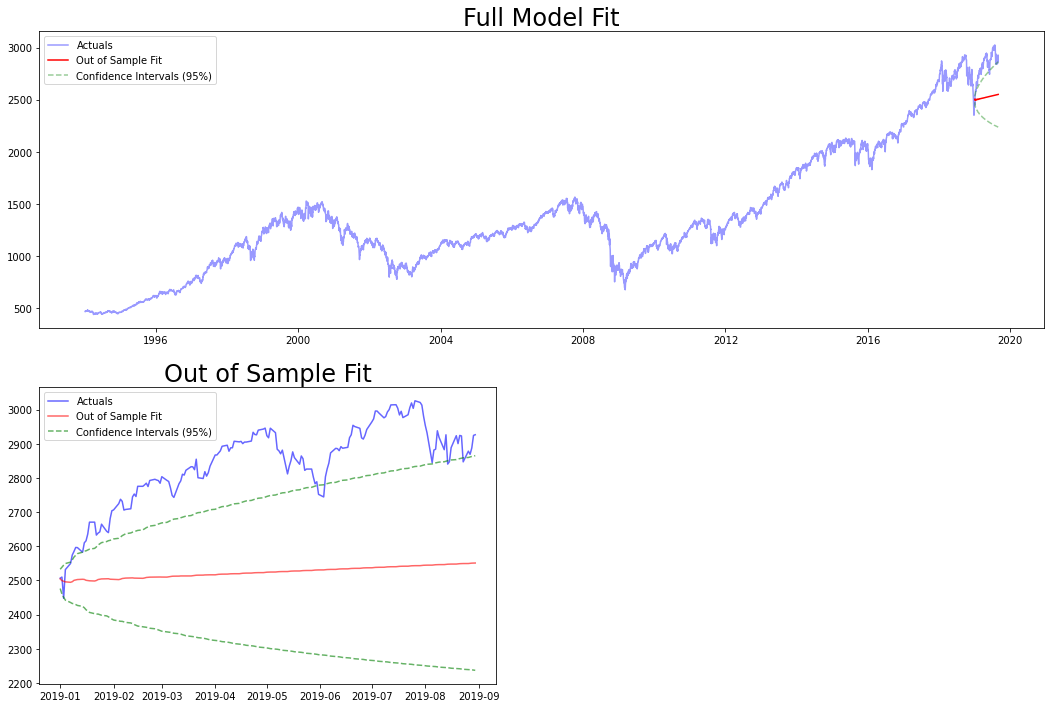

In [33]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

5.18

In [34]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.7 MB/s eta 0:00:00


In [35]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=26.67 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=57943.325, Time=1.45 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=55834.625, Time=3.12 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=17.66 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=57939.123, Time=0.51 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=55138.362, Time=4.51 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=24.26 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=15.62 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=55142.946, Time=2.32 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=55124.504, Time=3.84 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=55827.531, Time=2.65 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=36.05 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=18.76 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=55125.927, Time=6.41 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=55141.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6518
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -27557.252
Date:                           Sun, 12 Mar 2023   AIC                          55124.504
Time:                                   07:34:17   BIC                          55158.411
Sample:                               01-06-1994   HQIC                         55136.230
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.008     -4.447      0.000      -0.048      -0.019
ar.L2         -0.0494      0.007     -7.204      0.000      -0.063      -0.036
ar.S.L5       -0.6999      0.007    -99.802      0.000      -0.714      -0.686
ar.S.L10      -0.3228      0.007    -43.233      0.000      -0.337      -0.308
sigma2       277.3268      2.423    114.438      0.000     272.577     282.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11066.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Интерполяция

<AxesSubplot:xlabel='Date'>

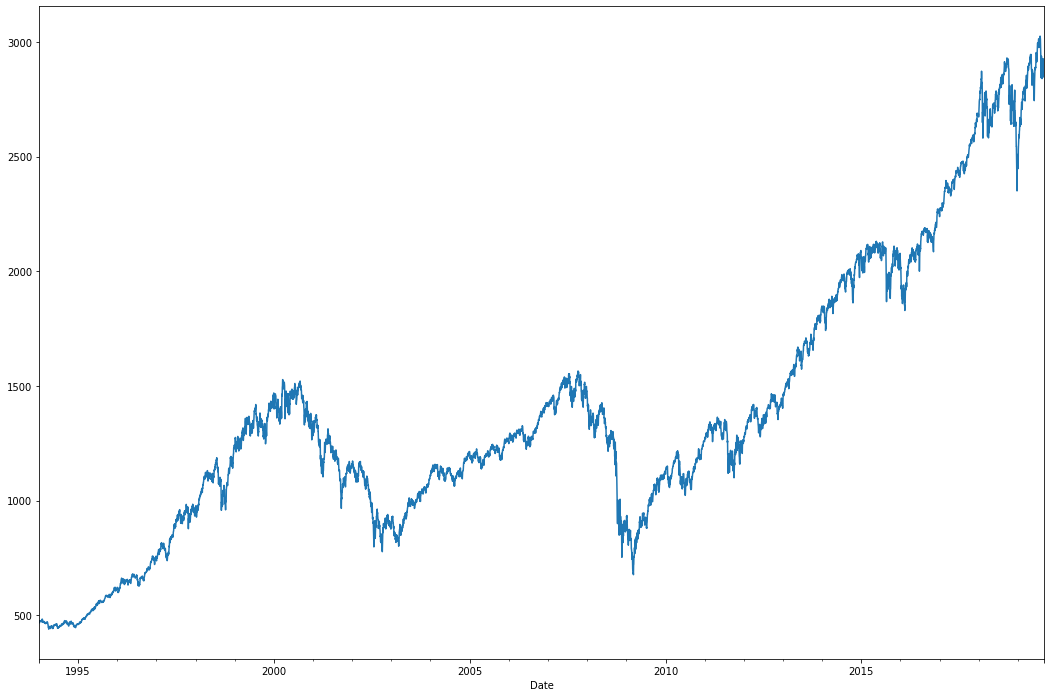

In [36]:
data.spx.plot()

In [38]:
data.shape

(6692, 1)

(1339, 1)

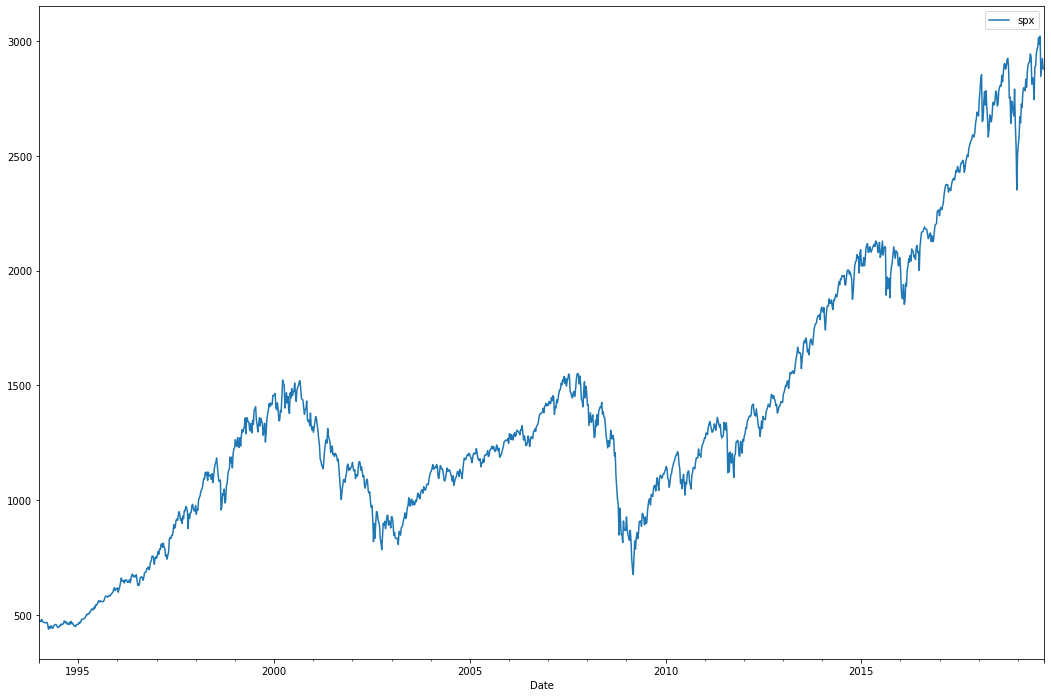

In [43]:
interpolated_data = pd.DataFrame(data.spx.resample('w-Mon').interpolate(), columns = ['spx'])
interpolated_data.plot()
interpolated_data.shape

In [44]:
interpolated_data.head()

,spx
Date,
1994-01-10,475.269989
1994-01-17,473.299988
1994-01-24,471.970001
1994-01-31,481.609985
1994-02-07,471.760010


In [45]:
train_df = interpolated_data.loc[:'2018-12-31']
test_df = interpolated_data.loc['2019-01-01':]
train_df.shape, test_df.shape

((1304, 1), (35, 1))

Построим карролерограмму

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


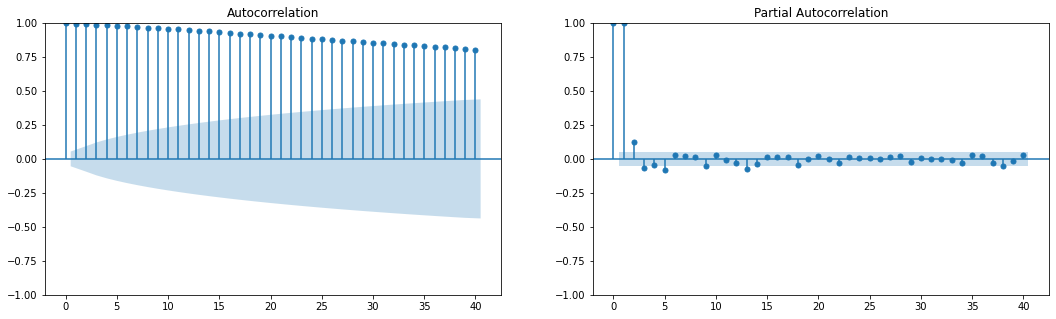

(-0.2607657143116782,
 0.9308801996019748,
 10,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12512.497637173248)

In [47]:
plot_acf_pacf(train_df.spx.dropna())
adfuller(train_df.spx.dropna()) #тест дики фуллера

Ряд не является стационарным

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


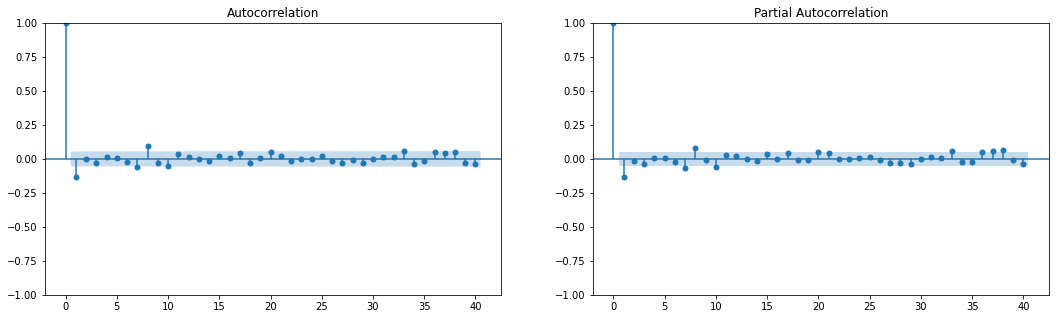

(-11.946377875600588,
 4.420358877552662e-22,
 9,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12501.713967337682)

In [48]:
plot_acf_pacf(train_df.spx.diff(1).dropna()) #Дифференцирование ряда:
adfuller(train_df.spx.diff(1).dropna()) #тест дики фуллера

In [49]:
#ARIMA
arima_model = ARIMA(train_df.spx.dropna(), order = (1,1,1))
arima_model_fir = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26625.675
Date:                Sun, 12 Mar 2023   AIC                          53257.350
Time:                        07:54:21   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Волатильность

Функция Pandas Shift(), сдвигает индекс на желаемое количество периодов. Эта функция принимает скалярный параметр, называемый периодом, который представляет количество сдвигов для желаемой оси

In [54]:
#Считаем волатильность по формле
data['spx_vol1'] = (data.spx-data.spx.shift(1))/data.spx.shift(1)*100

In [57]:
#либо с помощью функции
data['spx_vol'] = data.spx.pct_change(1).mul(100).abs()
data

,spx,spx_vol1,spx_vol
Date,,,
1994-01-06,467.119995,NaN,NaN
1994-01-07,469.899994,0.595136,0.595136
1994-01-10,475.269989,1.142795,1.142795
1994-01-11,474.130005,-0.239860,0.239860
1994-01-12,474.170013,0.008438,0.008438
...,...,...,...
2019-08-26,2878.379883,1.098299,1.098299
2019-08-27,2869.159912,-0.320318,0.320318
2019-08-28,2887.939941,0.654548,0.654548


<AxesSubplot:xlabel='Date'>

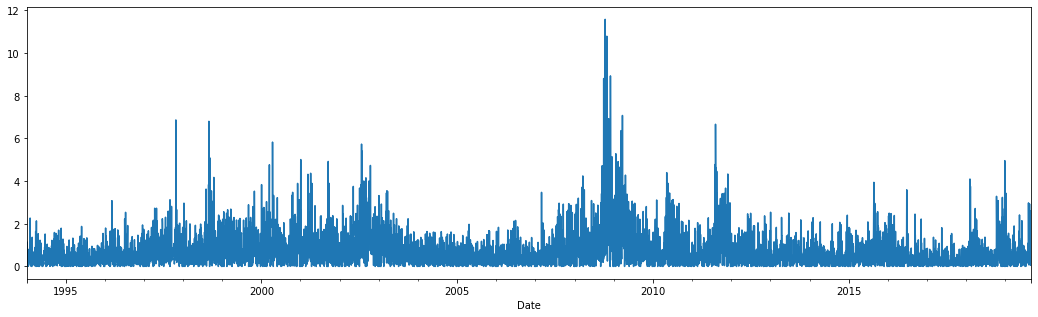

In [58]:
data['spx_vol'].plot()

Карролирограмма частичной автокорреляции

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


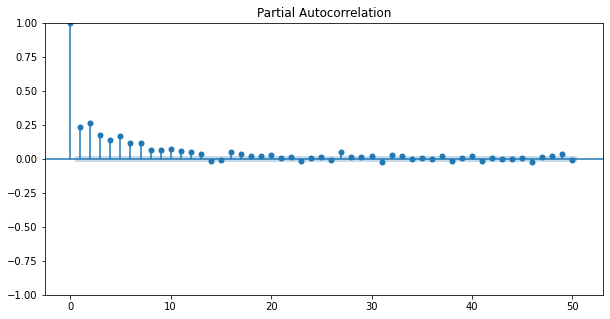

In [60]:
train_df = data.loc[:'2018-12-31']
test_df = data.loc['2019-01-01':]

plt.rcParams['figure.figsize'] = 10,5

sgt.plot_pacf(train_df.spx_vol[1:], lags = 50)
plt.show()

In [62]:
#тест дики-фуллера
adfuller(train_df.spx_vol[1:])

(-6.39534922529237,
 2.0573554561901765e-08,
 32,
 6484,
 {'1%': -3.4313589282423522,
  '5%': -2.8619858596459524,
  '10%': -2.567007327763762},
 14596.425117785417)

Т.к. нужен 2 лаг. строим модель GARCH(2,2)

In [63]:
garch_df = pd.DataFrame(data['spx_vol'].shift(1).loc[data.index])
garch_df.at[train_df.index, 'spx_vol'] = train_df['spx_vol'].dropna()

In [65]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 16.2 MB/s eta 0:00:00


In [66]:
from arch import arch_model

dropna() – удаление строк, где есть пропущенные значения.

In [70]:
model = arch_model(garch_df['spx_vol'].dropna(), p=2, q=2, vol = 'GARCH')
model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     50,   Neg. LLF: 7099.575053673434
Iteration:     10,   Func. Count:     90,   Neg. LLF: 6534.059785845555
Iteration:     15,   Func. Count:    128,   Neg. LLF: 6509.361020332575
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6509.361009200937
            Iterations: 17
            Function evaluations: 141
            Gradient evaluations: 17


In [71]:
from sklearn.metrics import ndcg_score, dcg_score
import numpy as np

In [72]:
true = np.asarray([[2, 4, 1, 1, 1]])
relevance = np.asarray([[2, 5, 2, 3, 1]])

print(ndcg_score(true, relevance))

0.9748317848747132
